<a href="https://colab.research.google.com/github/benmellin/wildfire-prediction/blob/main/decisiontree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Evaluation

The purpose of this project is to apply a decision tree model to predict occurance of a wildfire, based on NASA satellite measurement data. In this notebook, I build a decision tree model, tune the relevant hyper parameters, and then identify feature importance in the tree's decision making.

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Upload our precleaned data.

In [ ]:
import pandas as pd
import os
import csv
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Change directory to where you want files saved
os.chdir('/content/drive/MyDrive/ALDA Project/Data')

import os
os.listdir('/content/drive/MyDrive/ALDA Project/Data')


# File containing all data
data = pd.read_csv("combined_data_fixed.csv")



X = pd.DataFrame(data)


# Drop the response from X
X.drop("FIRE", axis = 1, inplace = True)
X.drop("Date", axis = 1, inplace = True)

# Assign y to the 'FIRE' column in data
y = data['FIRE']

# Set seed for reproducability
X_train_all, X_test, y_train_all, y_test, data_train_all, data_test = train_test_split(X, y, data, test_size = 0.2, random_state = 1234)

#create validation set
X_train, X_val, y_train, y_val, data_train, data_val = train_test_split(X_train_all, y_train_all, data_train_all, test_size = 0.2, random_state = 1234)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(19168, 12)
(5990, 12)
(19168,)
(5990,)
(4792, 12)
(4792,)


Create necessary methods

,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1
0,Decision Tree,1.0,0.959265,1.0,0.956744,1.0,0.960014,1.0,0.958376



Training Decision Tree...


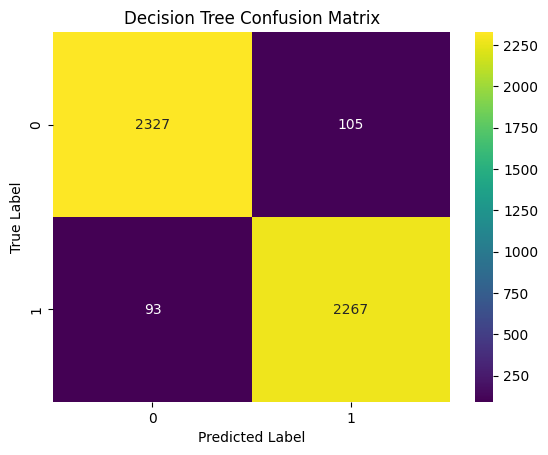

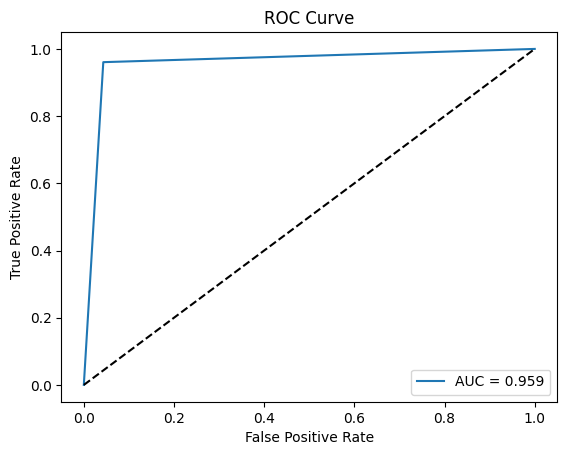

Tree depth: 29


In [ ]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay)

# A method to evaluate pipelines used
def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):
    rows = []
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        test_preds = pipeline.predict(X_test)

        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)

        training_recall = recall_score(y_train, train_preds)
        testing_recall = recall_score(y_test, test_preds)

        training_precision = precision_score(y_train, train_preds)
        testing_precision = precision_score(y_test, test_preds)

        training_f1 = f1_score(y_train, train_preds)
        testing_f1 = f1_score(y_test, test_preds)

        rows.append({'name': name, 'Training Accuracy': training_accuracy, 'Eval Accuracy': testing_accuracy,
                     'Training Recall': training_recall, 'Eval Recall': testing_recall,
                     'Training Precision': training_precision, 'Eval Precision': testing_precision,
                     'Training F1': training_f1, 'Eval F1': testing_f1})

    display(pd.DataFrame(rows))

# Plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, clf_name):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure()

    # Use seaborn to plot confusion matrix
    sns.heatmap(cm, annot = True, fmt = 'g', cmap='viridis')

    # Labels/title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{clf_name} Confusion Matrix')

    # Display plot
    plt.show()


def plot_roc_curve(y_test, y_probs):

  #calculate auc
  auc = roc_auc_score(y_test, y_probs)

  #plot
  fpr, tpr, _ = roc_curve(y_test, y_probs)
  plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.show()


## Try out the methods
decision_tree = make_pipeline(DecisionTreeClassifier(random_state=1234))


evaluate_pipelines([

    ('Decision Tree', decision_tree)

], X_train, y_train, X_val, y_val)

# CLFs to plot confusion matrix for
clfs = [
        ('Decision Tree', decision_tree)]

for name, clf in clfs:

    #train
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)

    #Predict and evaluate
    y_pred = clf.predict(X_val)
    y_probs = clf.predict_proba(X_val)[:, 1]
    plot_confusion_matrix(y_val, y_pred, name)
    plot_roc_curve(y_val, y_probs)

    # Get depth
    tree = clf.named_steps['decisiontreeclassifier']

    depth = tree.get_depth()
    print(f"Tree depth: {depth}")

## Tuning Hyperparameters
- We've established a high baseline accuracy for decision trees here, with train and validation set only.
- Tune HPs to increase AUC score

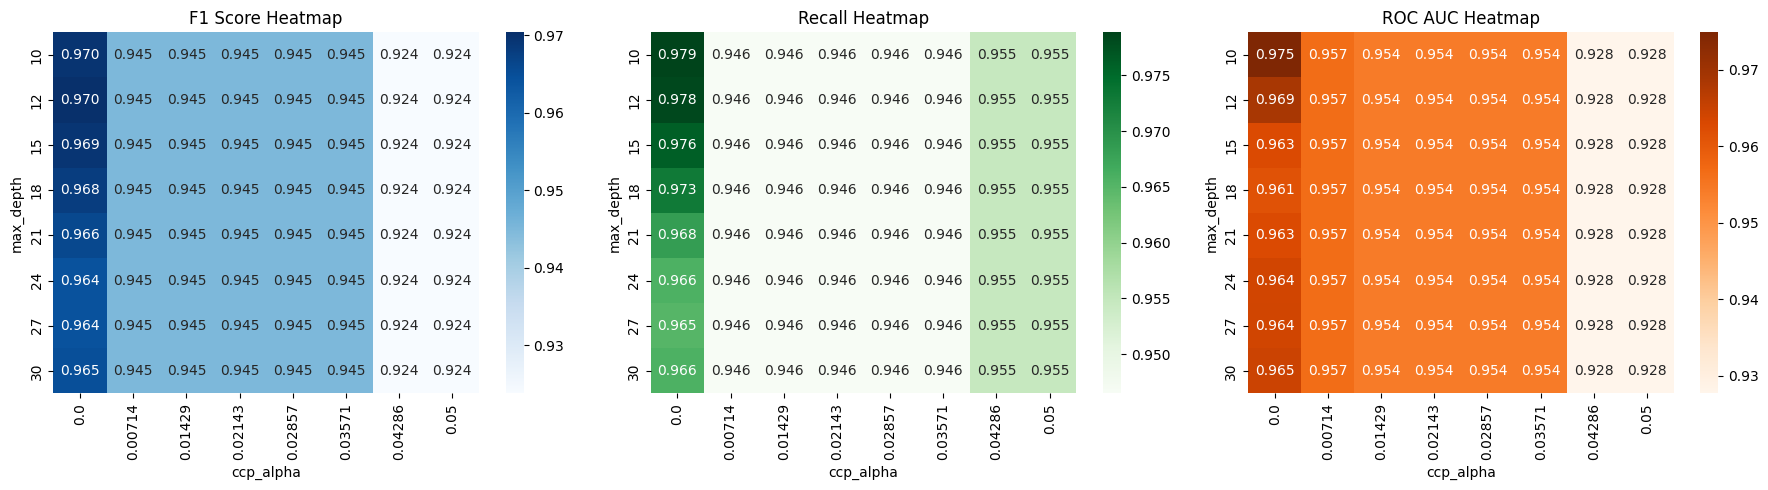

In [ ]:
##5 fold CV

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.05, 8)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(10, 30, num=8, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()


## More Hyperparameter Tuning
- Based on the previous heatmaps, seems like a very small alpha is best
- I'm going to narrow in the upper left corners of the heatmaps
- Note that I'm thinking about how to maximizing ROC AUC, because I believe this is the most important metric in the context of fire detection

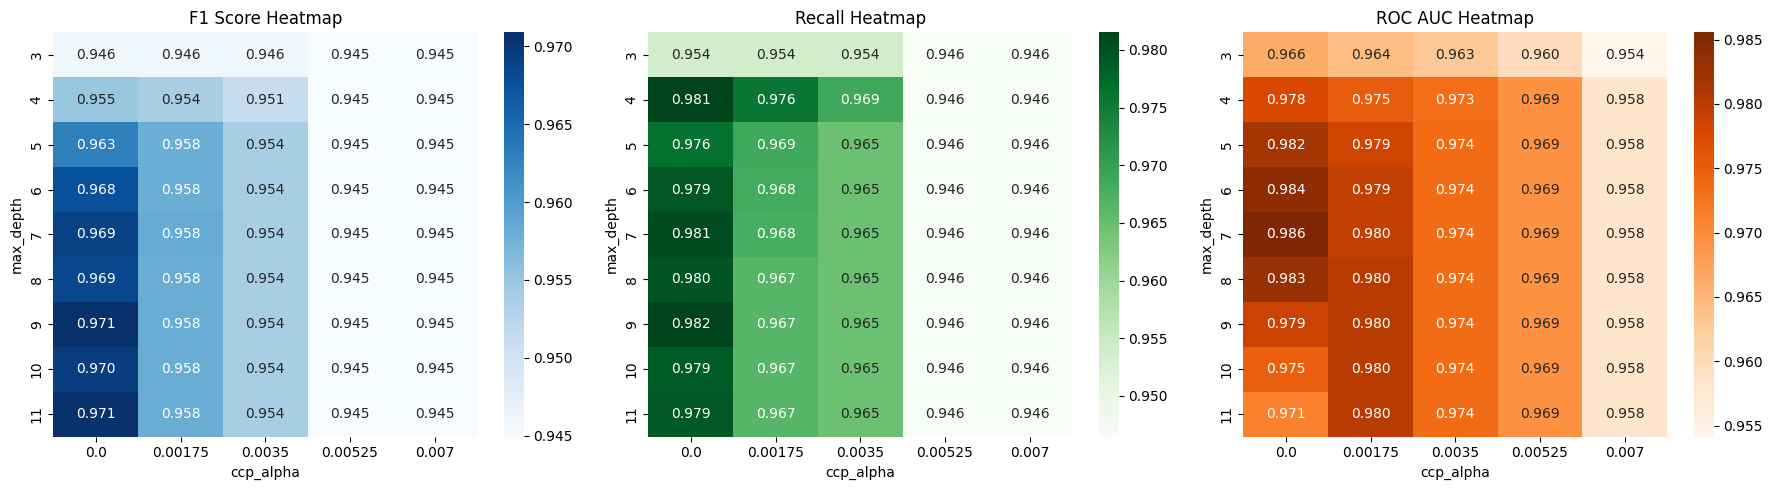

In [ ]:
# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.007, 5)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(3, 11, num=9, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()

## One more round of HP tuning to zero in on optimal range of CCCP alpha

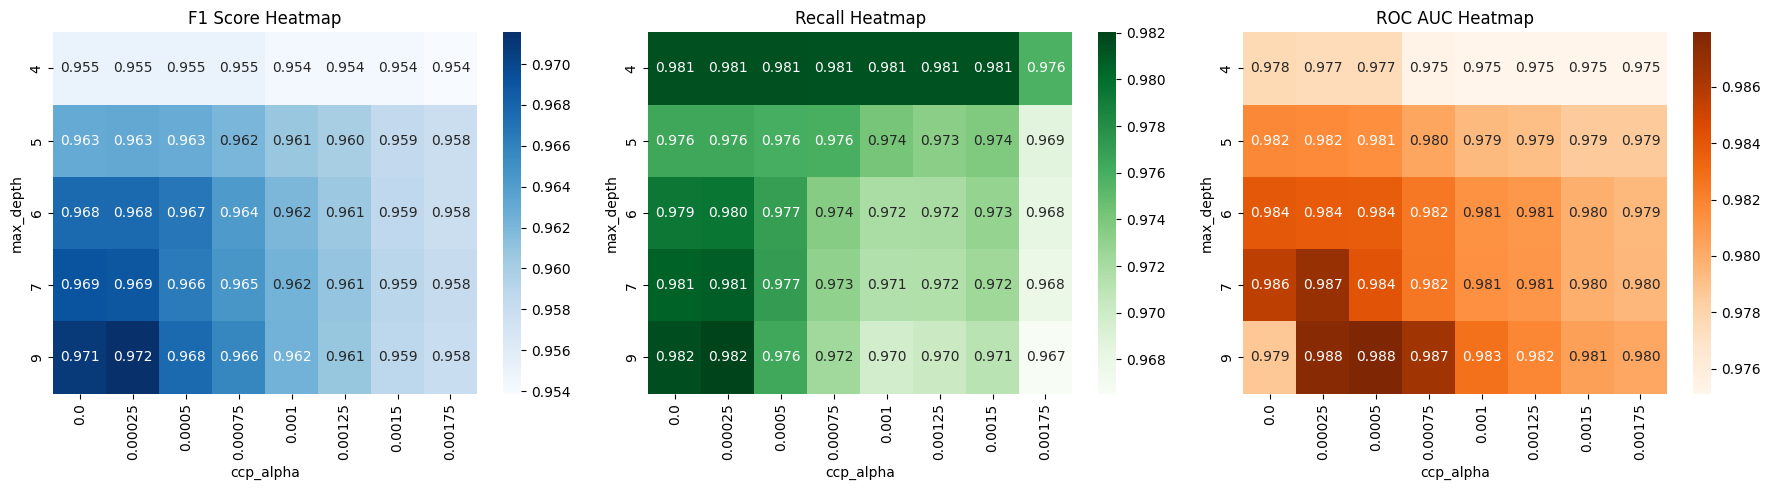

In [ ]:
# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.00175, 8)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(4, 9, num=5, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()



## One more round


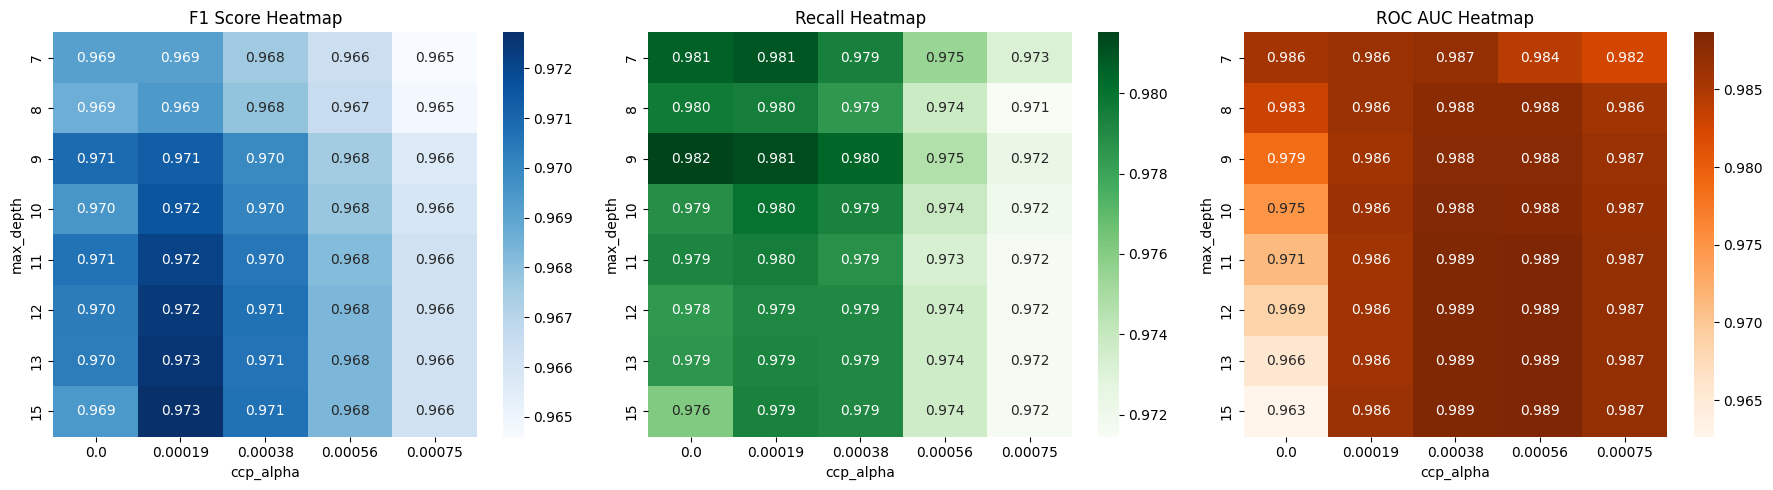

In [ ]:
## Final Round
# Generate a reasonable range for alpha tuning
alphas = np.linspace(0, 0.00075, 5)

# Generate a reasonable range for max depth tuning
max_depths = np.linspace(7, 15, num=8, dtype=int)

# Initialize result dataframes
f1_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
recall_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))
roc_results = pd.DataFrame(index=max_depths, columns=np.round(alphas, 5))

# Perform grid search manually with 5-fold cross-validation
for depth in max_depths:
    for alpha in alphas:
        clf = DecisionTreeClassifier(max_depth=depth, ccp_alpha=alpha, random_state=1234)

        f1 = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(f1_score)).mean()
        recall = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring=make_scorer(recall_score)).mean()
        roc = cross_val_score(clf, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()

        col_key = round(alpha, 5)
        f1_results.loc[depth, col_key] = f1
        recall_results.loc[depth, col_key] = recall
        roc_results.loc[depth, col_key] = roc

# Convert to float for correct plotting
f1_results = f1_results.astype(float)
recall_results = recall_results.astype(float)
roc_results = roc_results.astype(float)

# Plot heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(f1_results, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 2)
sns.heatmap(recall_results, annot=True, fmt=".3f", cmap="Greens")
plt.title("Recall Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.subplot(1, 3, 3)
sns.heatmap(roc_results, annot=True, fmt=".3f", cmap="Oranges")
plt.title("ROC AUC Heatmap")
plt.xlabel("ccp_alpha")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()

I will opt for max_depth of 11, ccp_alpha of .00038. These maximize ROC AUC, but also have high values for f1 and Recall, while balancing a tree size that isn't too large.

## Creating Final Decision Tree
- Choosing hyperaparameter values seem to be max_depth of 8, and  ccp_alpha value of .00044. This is the simplest possible tree with the highest ROC.
- First I will get the stats for this on the test data set, then I will extract feature importance.


In [ ]:
print(data_test.head())

           Date  Latitude   Longitude  WS2M    T2M  T2M_MAX  T2M_MIN  T2MDEW  \
22895  20200805  39.89363 -105.504510  1.00  18.50    27.81    10.76    3.56   
24145  20000718  37.29306 -107.221670  0.51  16.52    26.04     8.91   -0.95   
24195  19900704  37.67361 -108.456940  0.75  23.35    31.28    14.67    4.68   
14286  20101008  36.96136  -99.565627  3.50  22.43    31.62    14.73    7.08   
28496  20190913  44.53806 -104.429440  1.91  15.07    23.65     6.26    5.58   

        RH2M     PS  ALLSKY_SFC_LW_DWN  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  \
22895  43.92  73.90              28.44              22.19                9.71   
24145  37.14  71.94              25.44              28.65                8.93   
24195  34.00  79.80              29.60              27.15               12.10   
14286  41.59  94.93              28.22              19.39                2.35   
28496  58.56  86.76              25.57              21.56                3.19   

       FIRE  
22895     1  
2414

,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1
0,Decision Tree,0.972579,0.966611,0.979774,0.970027,0.966024,0.962162,0.97285,0.966079



Training Decision Tree...


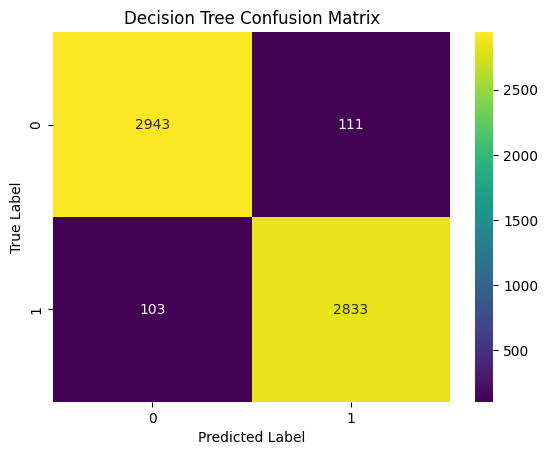

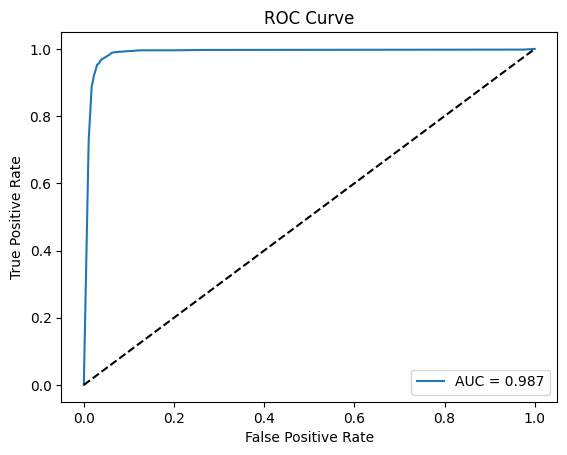

Tree depth: 10


In [ ]:

decision_tree = make_pipeline(DecisionTreeClassifier(max_depth=11, ccp_alpha=.00038,random_state=1234))


evaluate_pipelines([

    ('Decision Tree', decision_tree)

], X_train_all, y_train_all, X_test, y_test)

# CLFs to plot confusion matrix for
clfs = [
        ('Decision Tree', decision_tree)]

for name, clf in clfs:

    #train
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)

    #Predict and evaluate
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs)

    # Get depth
    final_tree = clf.named_steps['decisiontreeclassifier']

    depth = final_tree.get_depth()
    print(f"Tree depth: {depth}")

- The above tree has a very high AUC, and a very small recall.
- This is great!

## Now lets get an idea of feature importance.

               Feature  Importance
8                   PS    0.688597
0            Longitude    0.150427
1             Latitude    0.125369
4              T2M_MAX    0.014685
6               T2MDEW    0.009549
3                  T2M    0.004664
5              T2M_MIN    0.003069
2                 WS2M    0.001832
7                 RH2M    0.001807
9    ALLSKY_SFC_LW_DWN    0.000000
10   ALLSKY_SFC_SW_DWN    0.000000
11  ALLSKY_SFC_SW_DIFF    0.000000


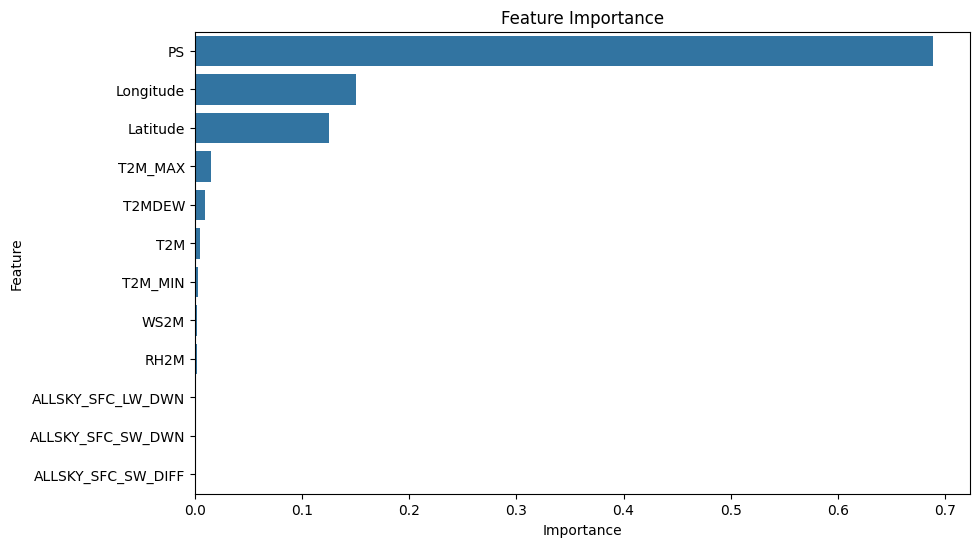

In [ ]:
# Get feature importances

importances = final_tree.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

               Feature  Importance
8                   PS    0.355130
0             Latitude    0.056772
1            Longitude    0.048066
2                 WS2M    0.008211
4              T2M_MAX    0.004581
5              T2M_MIN    0.001165
6               T2MDEW    0.000630
3                  T2M    0.000462
7                 RH2M    0.000153
9    ALLSKY_SFC_LW_DWN    0.000000
10   ALLSKY_SFC_SW_DWN    0.000000
11  ALLSKY_SFC_SW_DIFF    0.000000


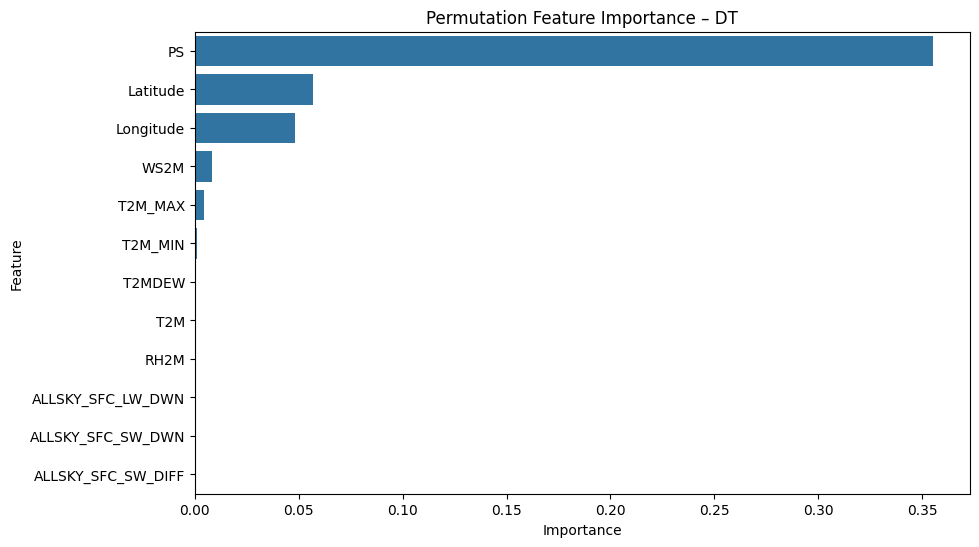

In [ ]:

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    estimator = final_tree,
    X         = X_test,
    y         = y_test,
    n_repeats = 15,
    scoring   = 'roc_auc',
    random_state = 1234,
    n_jobs    = -1,
)

# Put into a tidy DataFrame
perm_df = (pd.DataFrame({'Feature': X_test.columns,
                         'Importance': perm.importances_mean})
             .sort_values('Importance', ascending=False))

print(perm_df)

plt.figure(figsize=(10,6))
sns.barplot(y='Feature', x='Importance', data=perm_df)
plt.title("Permutation Feature Importance – DT")
plt.show()

## Looking at misclassifications
- Look at average PS for each class, lat and long for each class

In [ ]:
import pandas as pd

# Create a DataFrame with predictions and metadata
results_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'PS': data_test['PS'].values,
    'lat': data_test['Latitude'].values,
    'lon': data_test['Longitude'].values
})

# Group by confusion matrix cells: (true, pred)
grouped = results_df.groupby(['true', 'pred'])

# Compute mean PS, latitude, longitude for each cell
summary = grouped[['PS', 'lat', 'lon']].mean().reset_index()

print(summary)


   true  pred         PS        lat         lon
0     0     0  96.431599  37.167315  -95.103379
1     0     1  82.278532  41.156620 -107.071420
2     1     0  85.914955  43.478344 -106.559911
3     1     1  77.623278  39.990250 -106.629273
